# 1. Libraries and data import

In [51]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [53]:
# Load data
dat = pd.read_csv('Complete data.csv')
dat.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [54]:
# Set index on date
dat["datetime_au"] = pd.to_datetime(dat["datetime_au"])

In [55]:
#Check number of duplicate rows
print("Number of duplicate rows:", dat.duplicated().sum())

Number of duplicate rows: 0


In [56]:
dat1 = dat
#dat1 = dat1.reset_index() 
dat1 = dat1.rename(columns={"datetime_au": "date",
                            "avg_30_min_demand": "demand", 
                            "cd_next_24h": "CD",
                            "hd_next_24h": "HD"})
dat1.head()

date  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0 2016-01-01          1          0          0          0          0   
1 2016-01-02          1          0          0          0          0   
2 2016-01-03          1          0          0          0          1   
3 2016-01-04          1          0          0          0          0   
4 2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp   HD  \
0          329352.88                   48  20.704082      15.2      26.0  0.0   
1          323133.95                   48  20.572917      14.9      24.2  0.0   
2          317665.92                   48  21.130769      19.0      22.9  0.0   
3          353210.40                   48  20.144444      18.4      23.1  0.0   
4          358082.97                   48  18.904808      17.4      20.3  0.0   

         CD  precipitation  sunlight  
0  1.204082       2.140095      32.3  
1  1.072917       6.496326      23.2  
2  1.630769       8.562486      12.7  
3  0.644444       4.082204       7.6  
4  0.000000       9.977372       3.9  

[5 rows x 38 columns]

# 2. Exploratory data analysis

## 2.1. Box plots (Categorical vs. Demand)

In [57]:
# Add day and month categorical variables
bxp = dat1.copy()

# Add day and month categorical variables
bxp["day"] = bxp["date"].dt.day_name()
bxp["month"] = bxp["date"].dt.month_name()

# Order of categories
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

Text(0, 0.5, 'Average 30-min Demand')

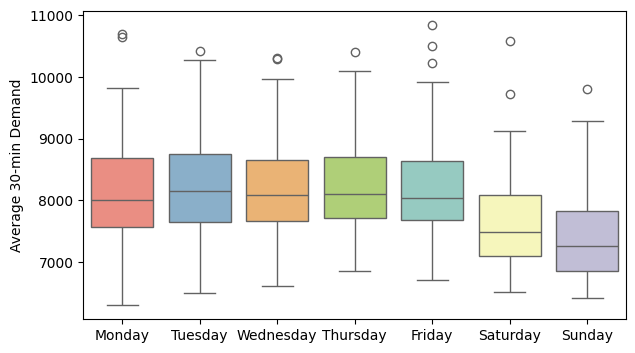

In [58]:
# 1. Electricity demand by "day of week"
plt.figure(figsize=(7,4))
sns.boxplot(data=bxp, x="day", hue="day",y="demand", order=day_order, palette="Set3")
plt.xlabel("")
plt.ylabel("Average 30-min Demand")
#NOTE: Two groups; Weekday and Weekend. Weekday (Mon-Fri) similar electricity demand and Weekend (Sat-Sun) similar demand.


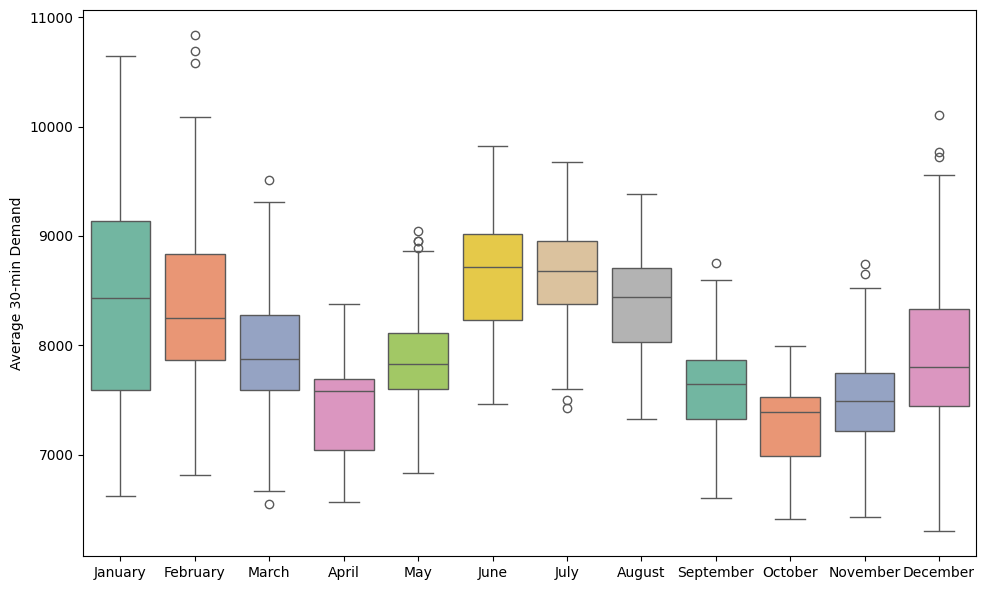

In [59]:
# 2. Electricity demand by Month
plt.figure(figsize=(10,6))
sns.boxplot(data=bxp, x="month", hue="month", y="demand", order=month_order, palette="Set2")
plt.xlabel("")
plt.ylabel("Average 30-min Demand")
plt.tight_layout()
#NOTE: Summer months; December, January, February => Similar demand distribution 
# Winter months; March and May similar demand distribution, however, notable lower demand in April
# Autumn months; June, July august => Similar demand distribution 
# Spring months; September, Oct, November => Similar demand distribution 

Text(0, 0.5, 'Average 30-min Demand')

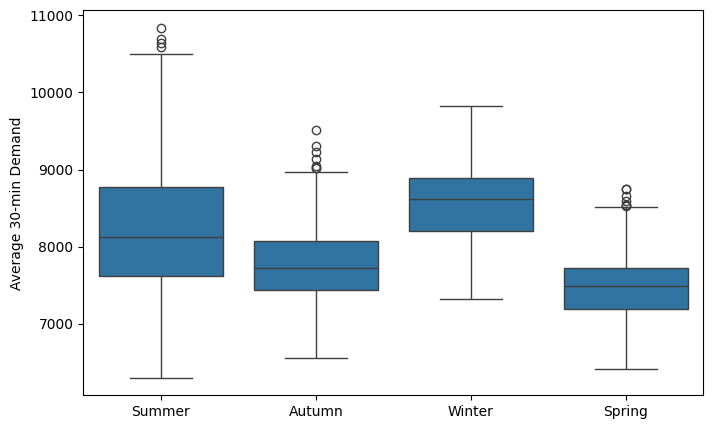

In [60]:
# Add month and season
bxp["month"] = bxp["date"].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

bxp["season"] = bxp["month"].apply(get_season)

# boxplot of demand w.r.t. seasons
plt.figure(figsize=(8, 5))
sns.boxplot(data=bxp, x="season", y="demand", order=["Summer", "Autumn", "Winter", "Spring"])
plt.xlabel("")
plt.ylabel("Average 30-min Demand")
#NOTE: Summer has highest demand (wide variation) but lower median (~ 8k), Winter has comparatively low variation but higher median (~8.5k). 
# Spring and Autumn collectively has similar demand.


## 2.2. Time series plots

In [61]:
# Response variable
response = "demand"

# Continuous predictors
cont_vars = ["min_30_min_demand", "max_30_min_demand", "avg_temp", "min_temp", "max_temp", "HD", "CD", "precipitation", "sunlight"]

# All variables (response + continuous predictors)
all_vars = [response] + cont_vars

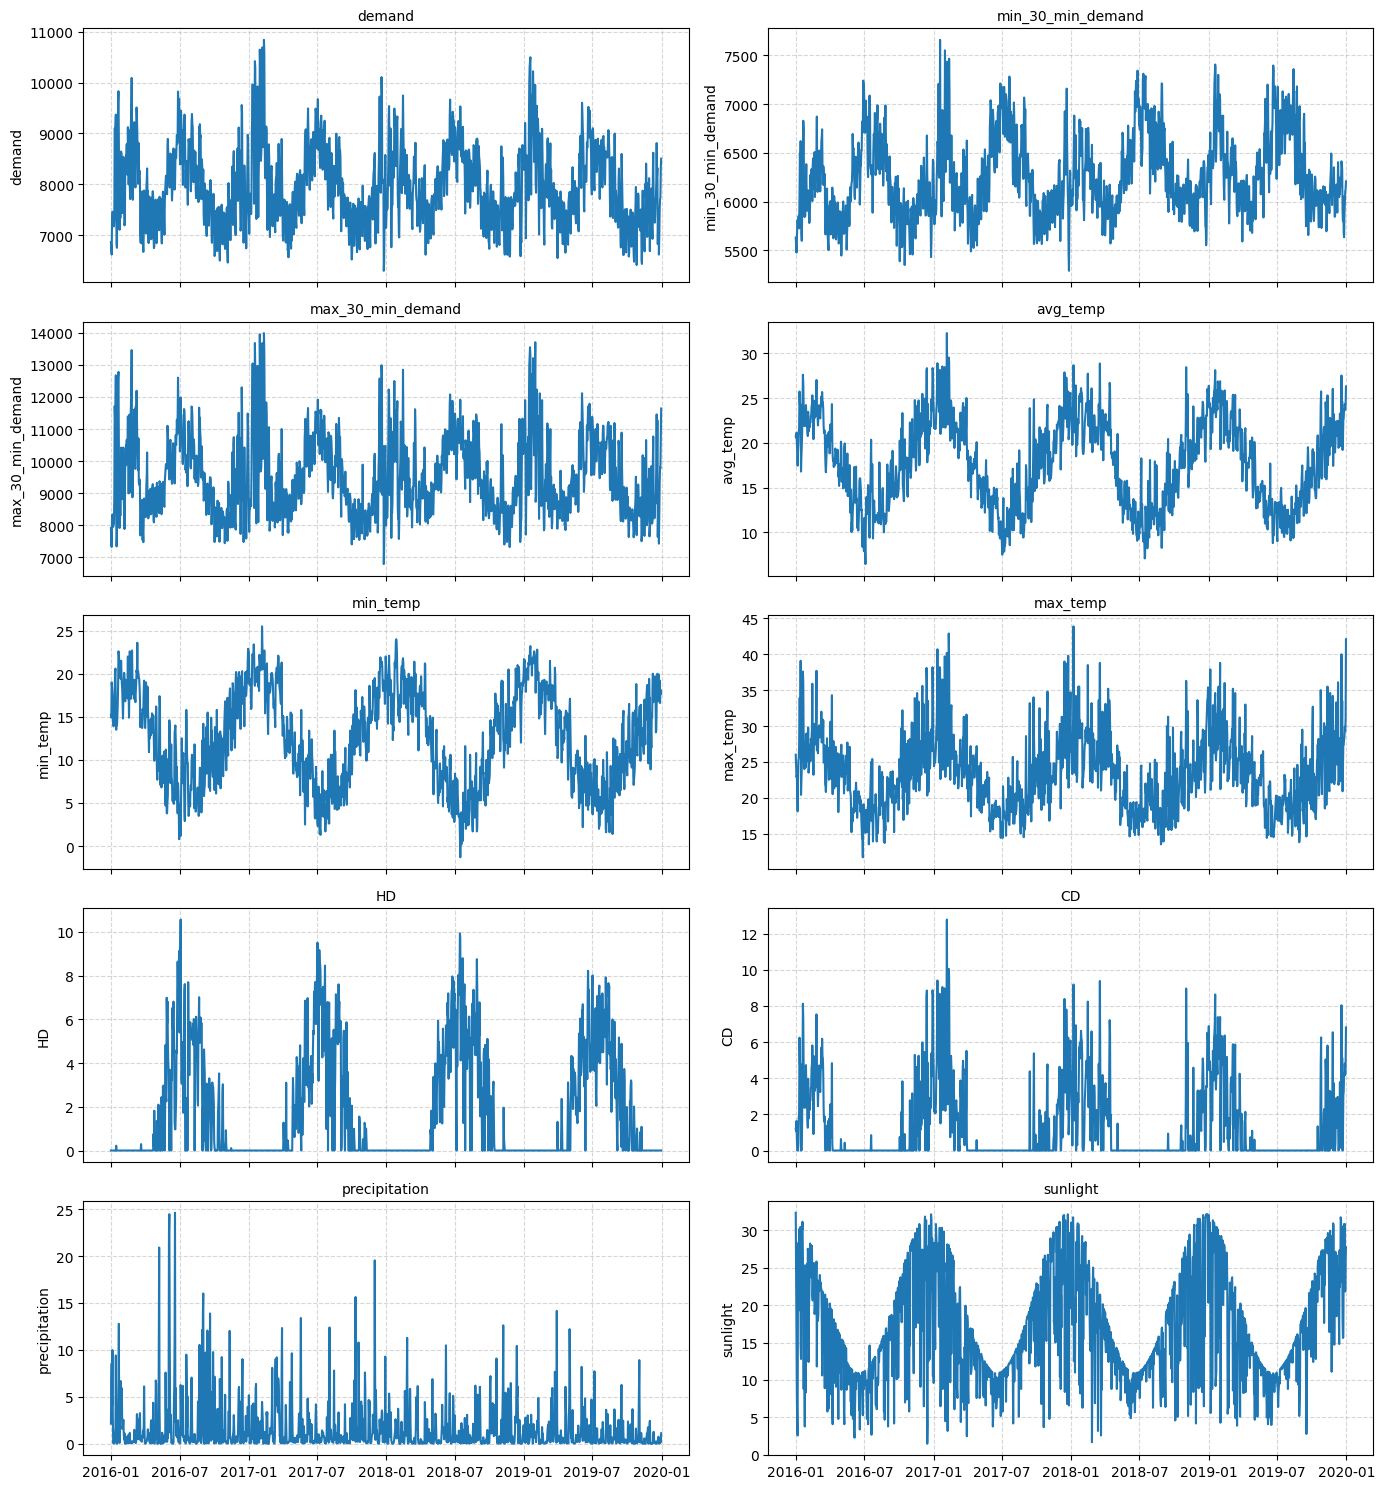

In [62]:
# layout for subplots
n_vars = len(all_vars)
ncols = 2
nrows = (n_vars + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 3 * nrows), sharex=True)
axes = axes.flatten()

# Each variable against time
for i, var in enumerate(all_vars):
    axes[i].plot(bxp["date"], bxp[var], label=var, color="tab:blue")
    axes[i].set_title(var, fontsize=10)
    axes[i].set_ylabel(var)
    axes[i].grid(True, linestyle="--", alpha=0.5)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

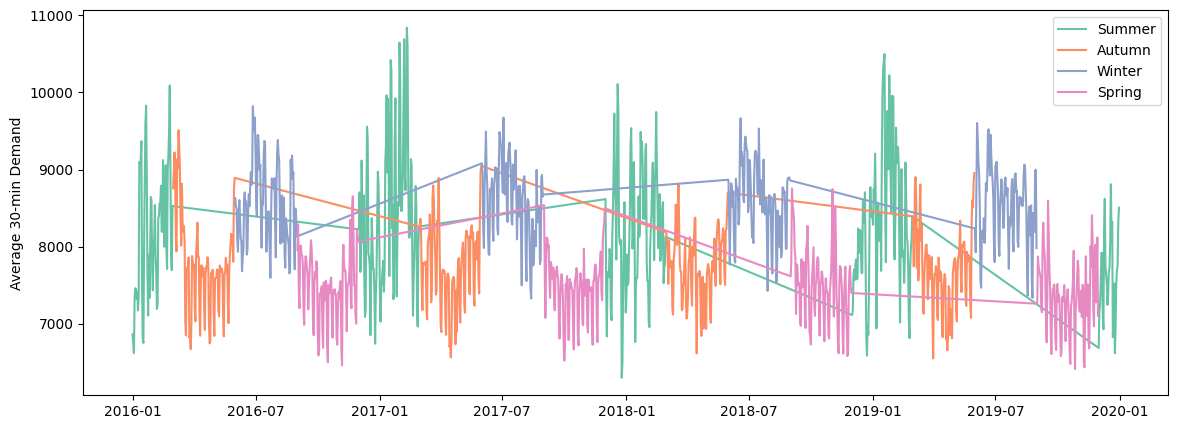

In [63]:
# Seasonal comparison of electricity demand
plt.figure(figsize=(14, 5))
sns.lineplot(data=bxp, x="date", y="demand", hue="season", palette="Set2")
plt.xlabel("")
plt.ylabel("Average 30-min Demand")
plt.legend(title="")
#NOTE: Summar has highest upward fluctuations; winter has similar behaviour but variations is lesser than as that of summer; 
# Autumn and Spring has similar pattern (mostly going downward in mid-season).
#NOTE: Based on this, features; summer, winter, Year, Month will be added "Feature engineering" part. Other seasons are excluded becasue of;
# (1) Summer and Winter has more dominant pattern than other seasones (2) This will also avoide extra dummy variables

## 2.3. Scatterplots (Numeric features vs. Demand)

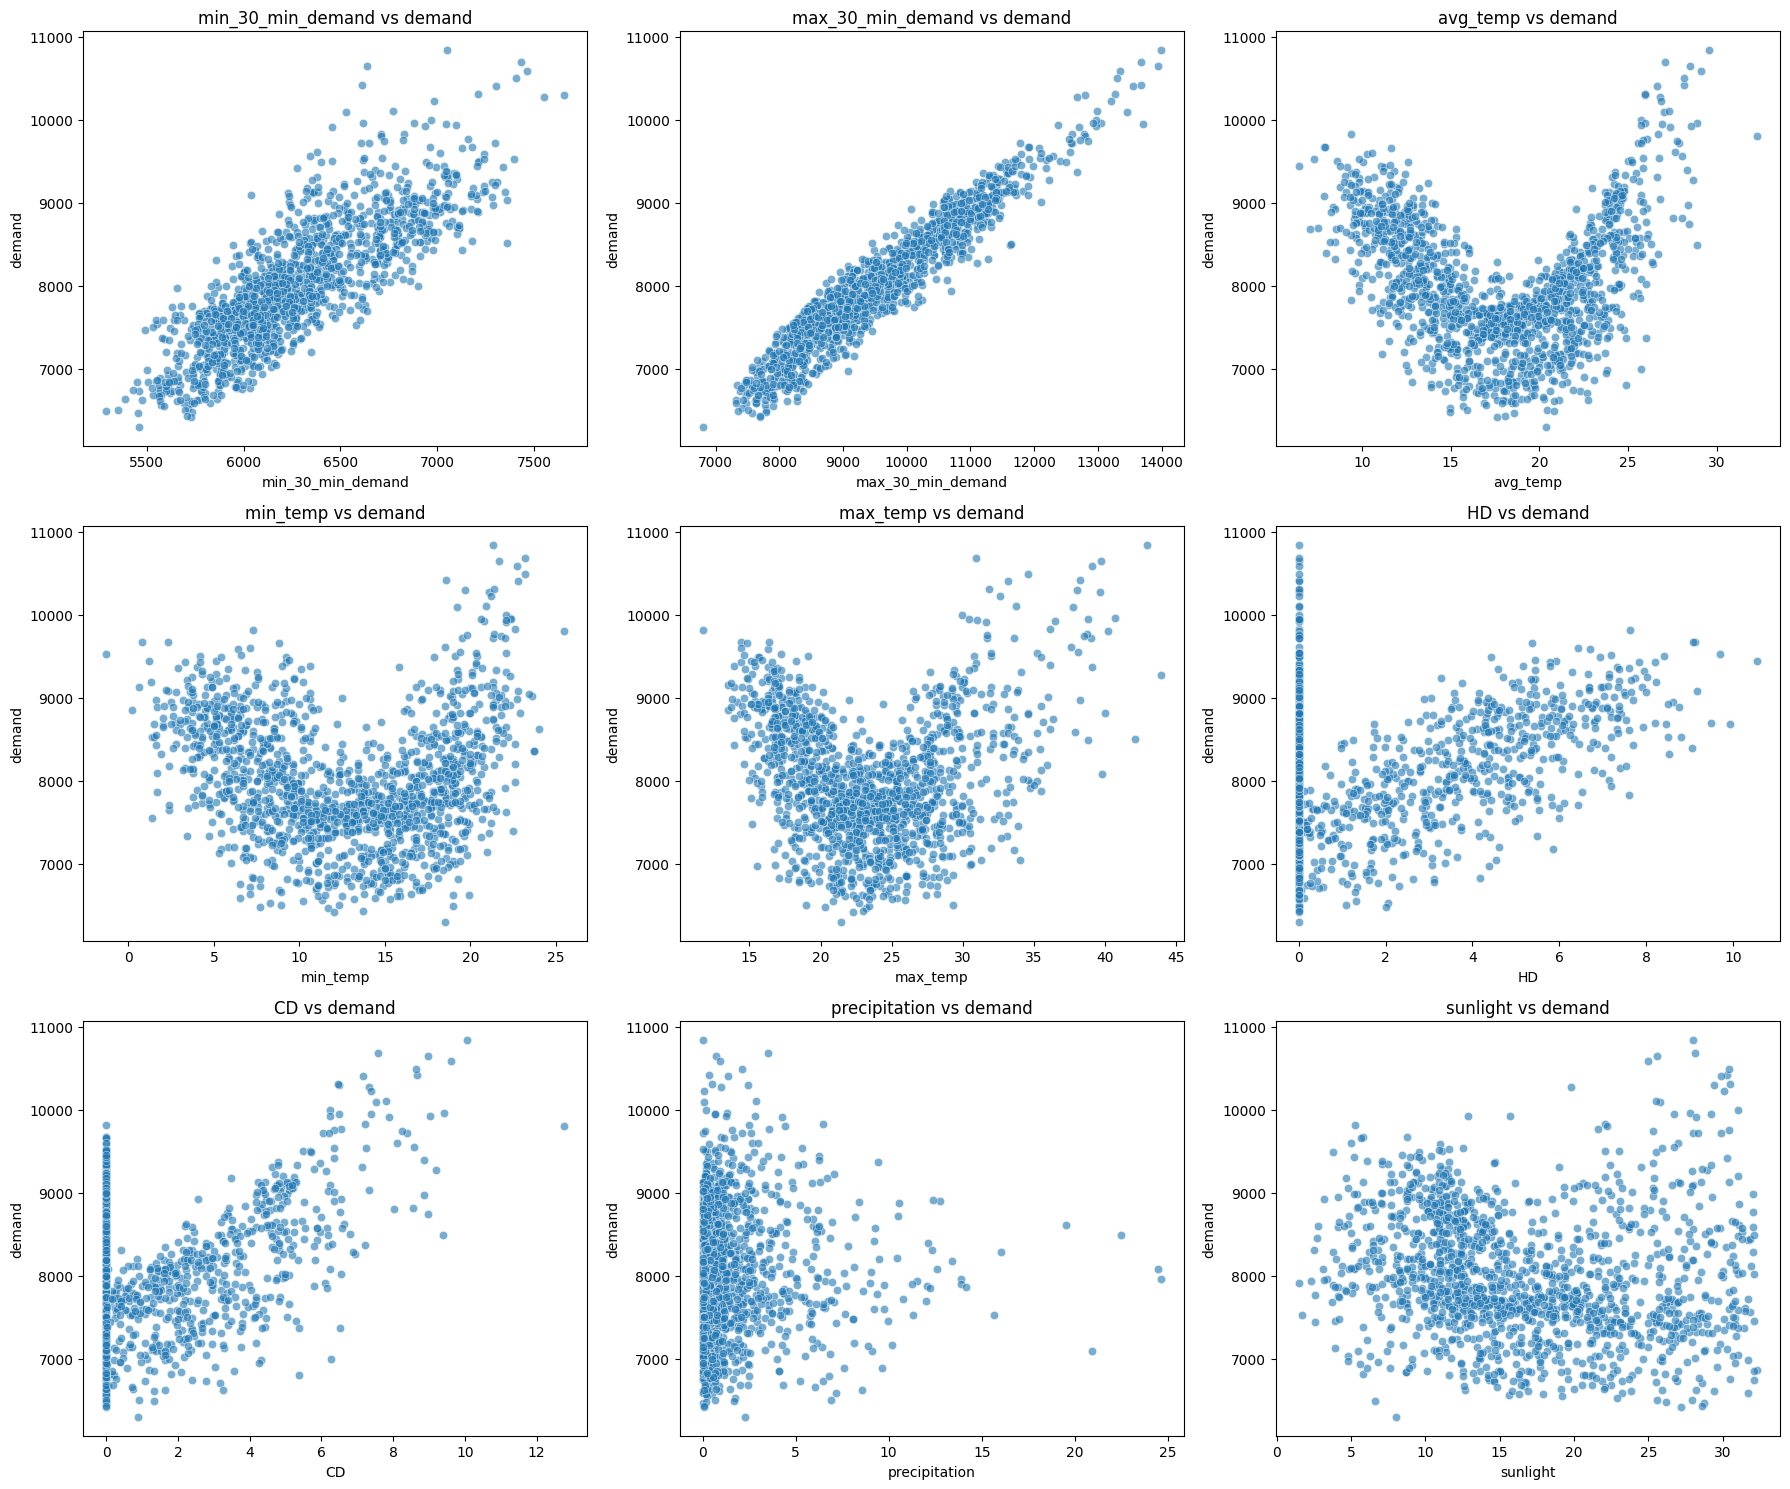

In [64]:
n_cols = 3
n_rows = (len(cont_vars) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, var in enumerate(cont_vars):
    sns.scatterplot(data=bxp, x=var, y=response, alpha=0.6, ax=axes[i])
    axes[i].set_title(f"{var} vs {response}")

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

#NOTE: Demand positively correlated with lag_min and lag_max demand. 
# Polynomial relation with Avg_temp, min_temp and max_temp (Polynomial of 2 will give a good fit)
# HD and CD also positively correlated but lots of '0' entries can influence the regression results. 
# Will add interaction of both of these (HD and CD) with winter and summer.
# Weak relation of Demand with sunligh exposure and precipitation espacially.

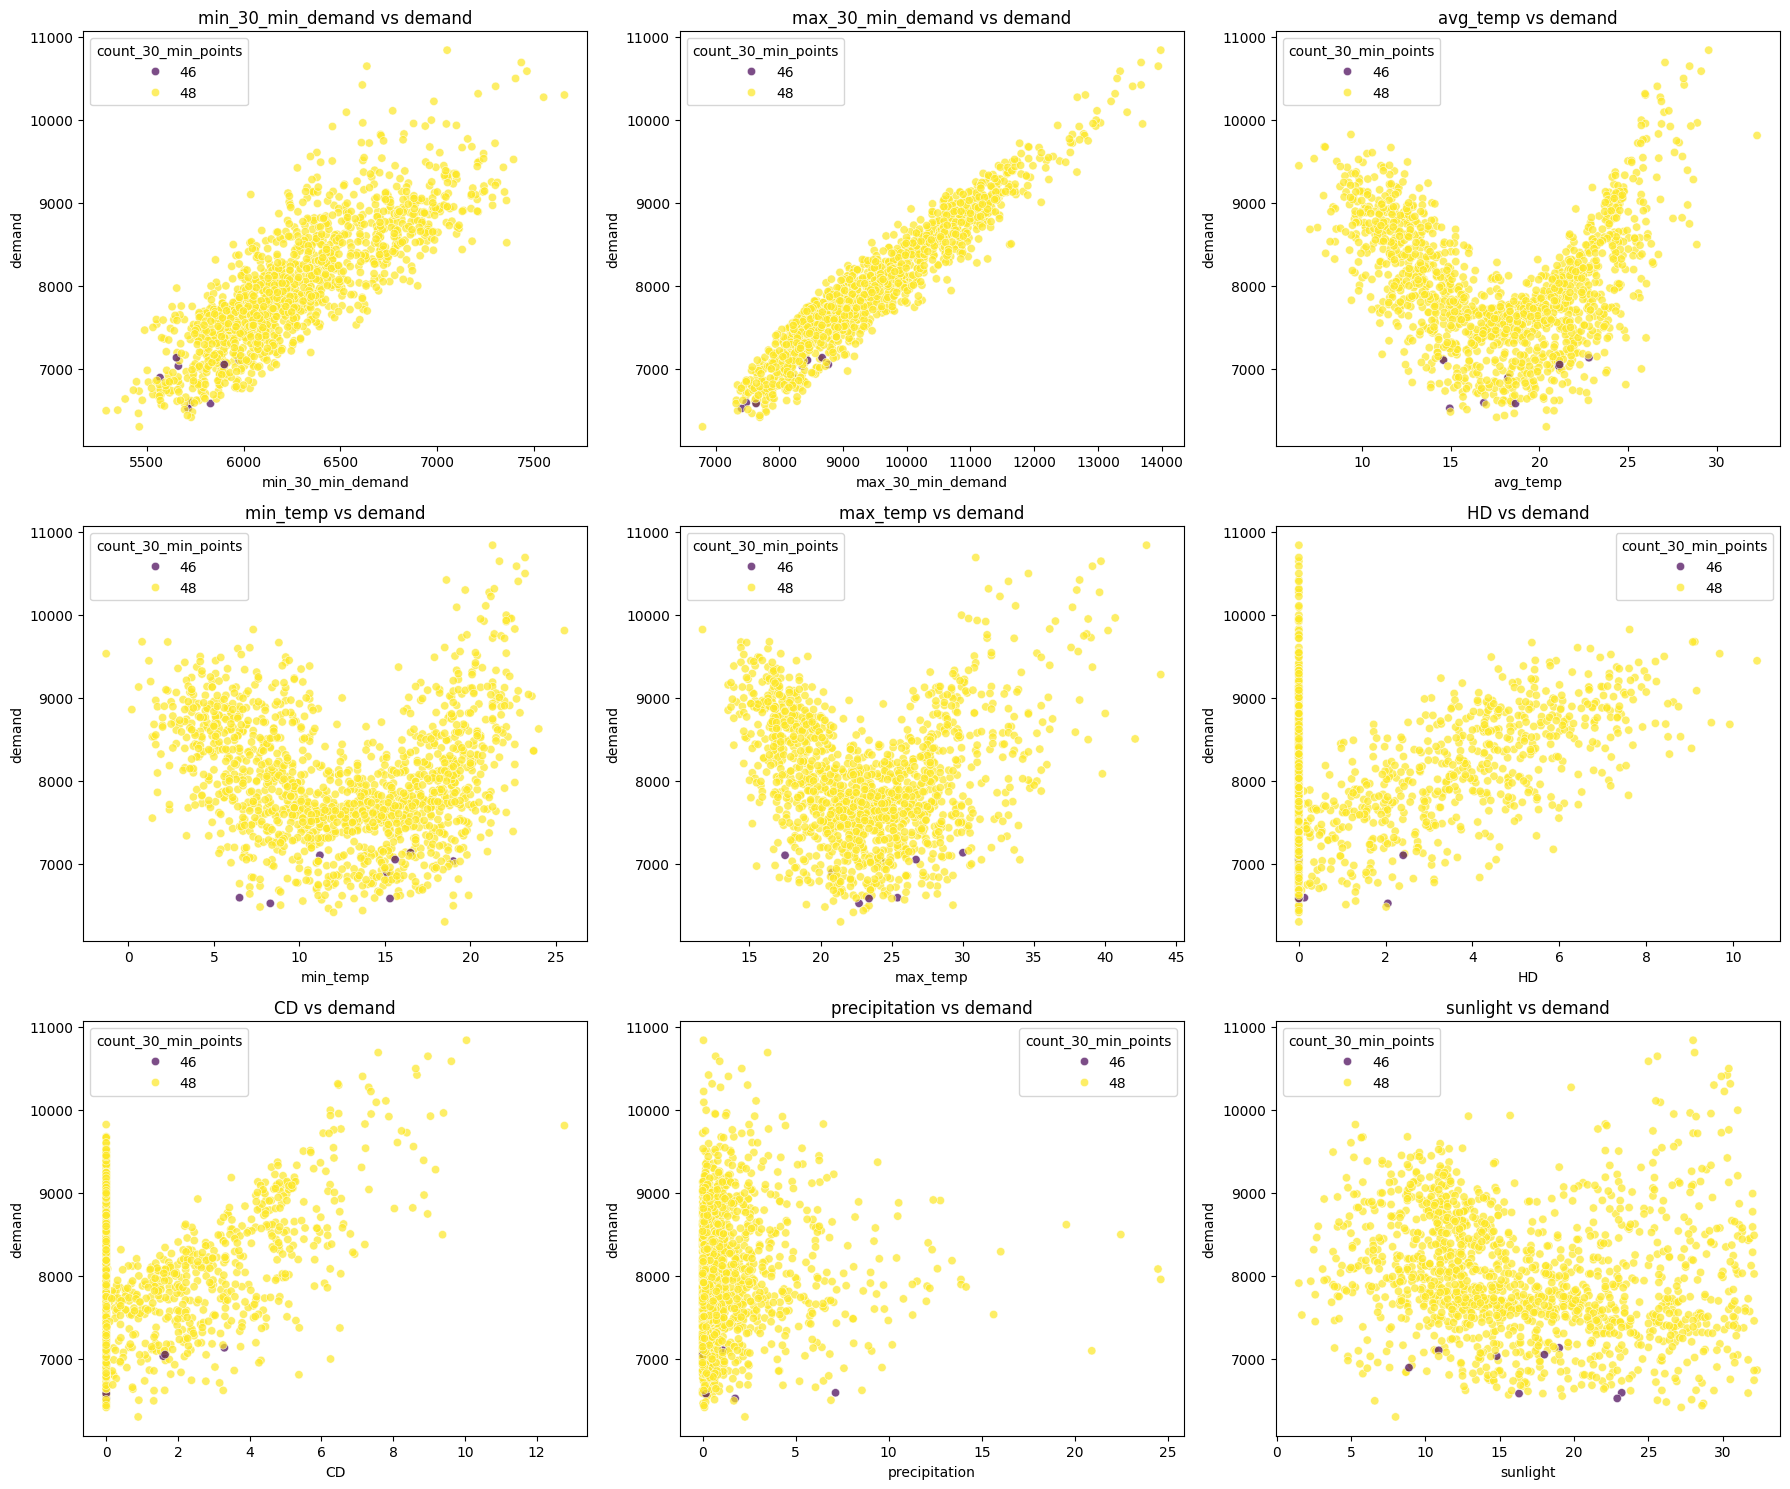

In [65]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, var in enumerate(cont_vars):
    sns.scatterplot(data=bxp, x=var, y=response, hue="count_30_min_points",  
                    palette="viridis", alpha=0.7, ax=axes[i])
    axes[i].set_title(f"{var} vs {response}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j]) # to remove empty subplots

plt.tight_layout()

#NOTE: Very few points for "46", This variable will not be used for analysis.

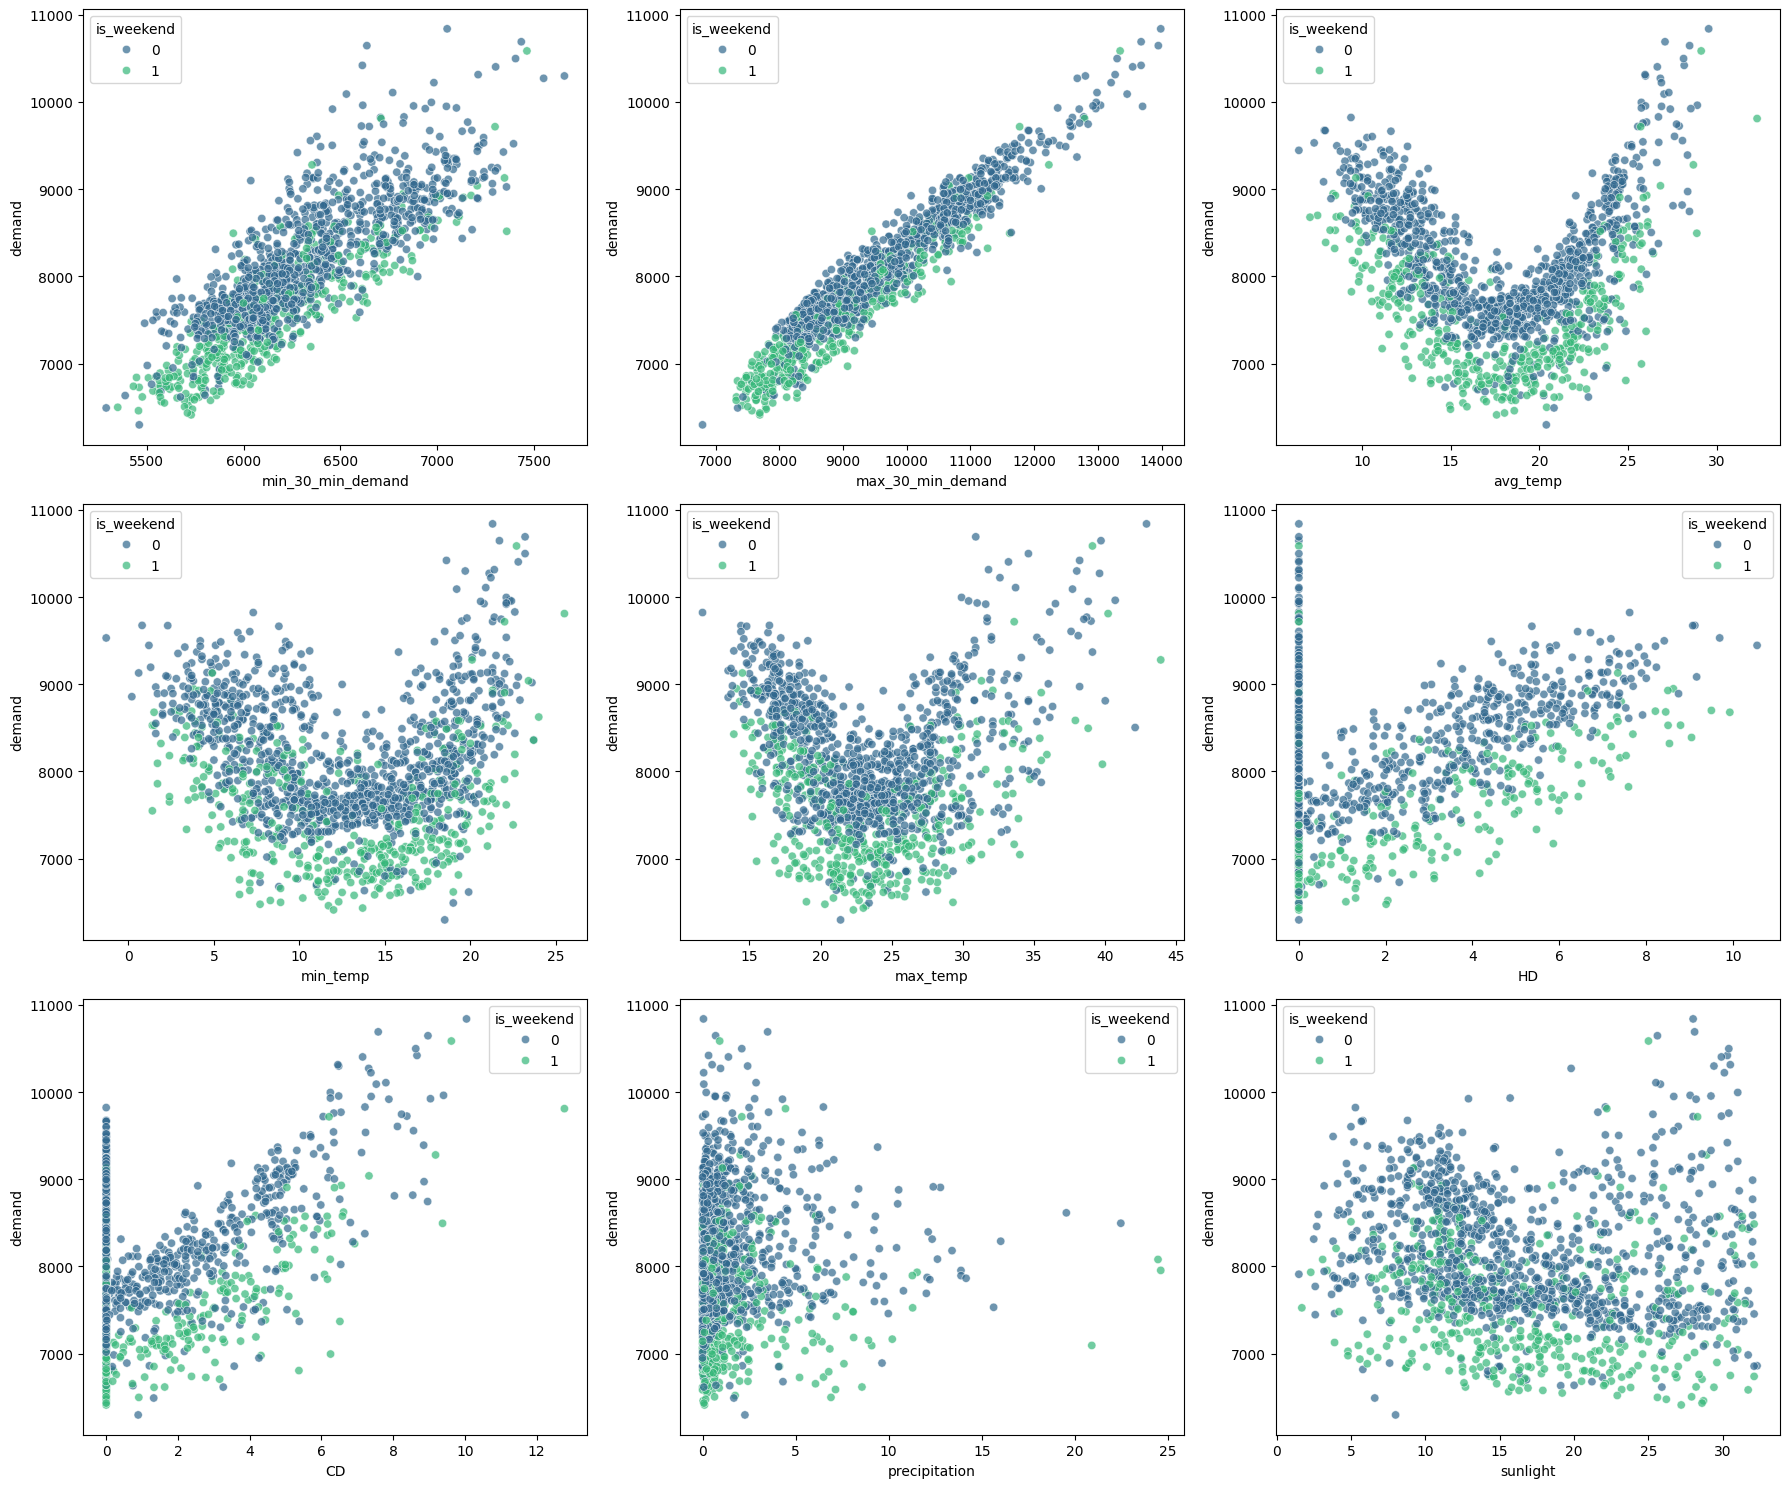

In [66]:
# Now to check for possible interactions of "is_weekend" with any of numeric features
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, var in enumerate(cont_vars):
    sns.scatterplot(data=bxp, x=var, y=response, hue="is_weekend",
                    palette="viridis", alpha=0.7, ax=axes[i])
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j]) # to remove empty subplots

plt.tight_layout()

#NOTE: Notable pattern of difference in electricity demand in lag_max_demand and temp-related features.


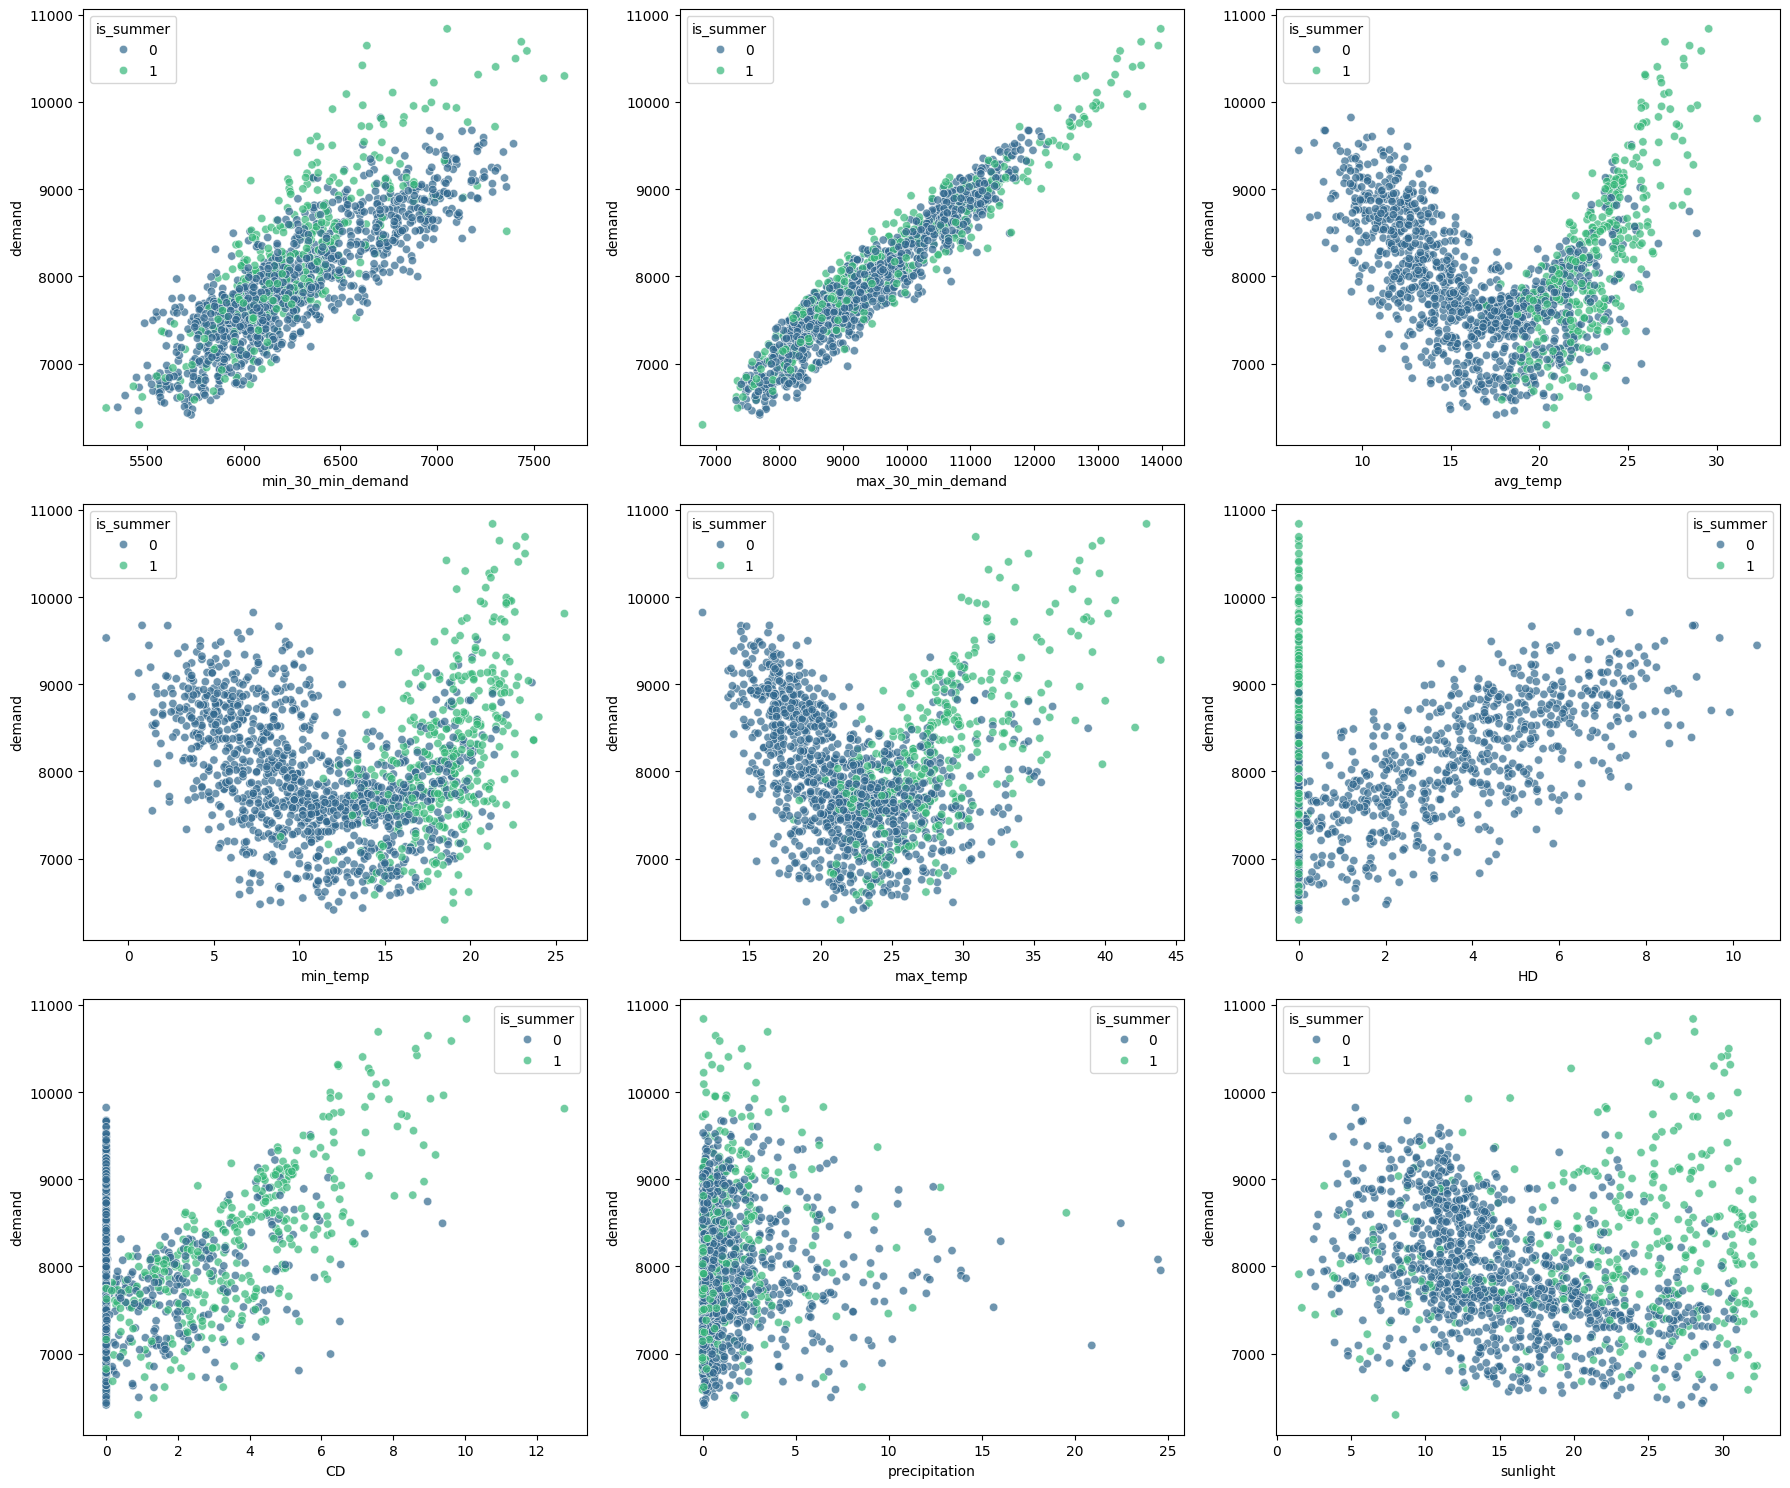

In [67]:
# To check for possible interactions of "is_summer" with any feature 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, var in enumerate(cont_vars):
    sns.scatterplot(data=bxp, x=var, y=response, hue="is_summer",
                    palette="viridis", alpha=0.7, ax=axes[i])
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j]) # to remove empty subplots

plt.tight_layout()

#NOTE: clear interaction of "is_summer" with avg_temp (or other temp related features)

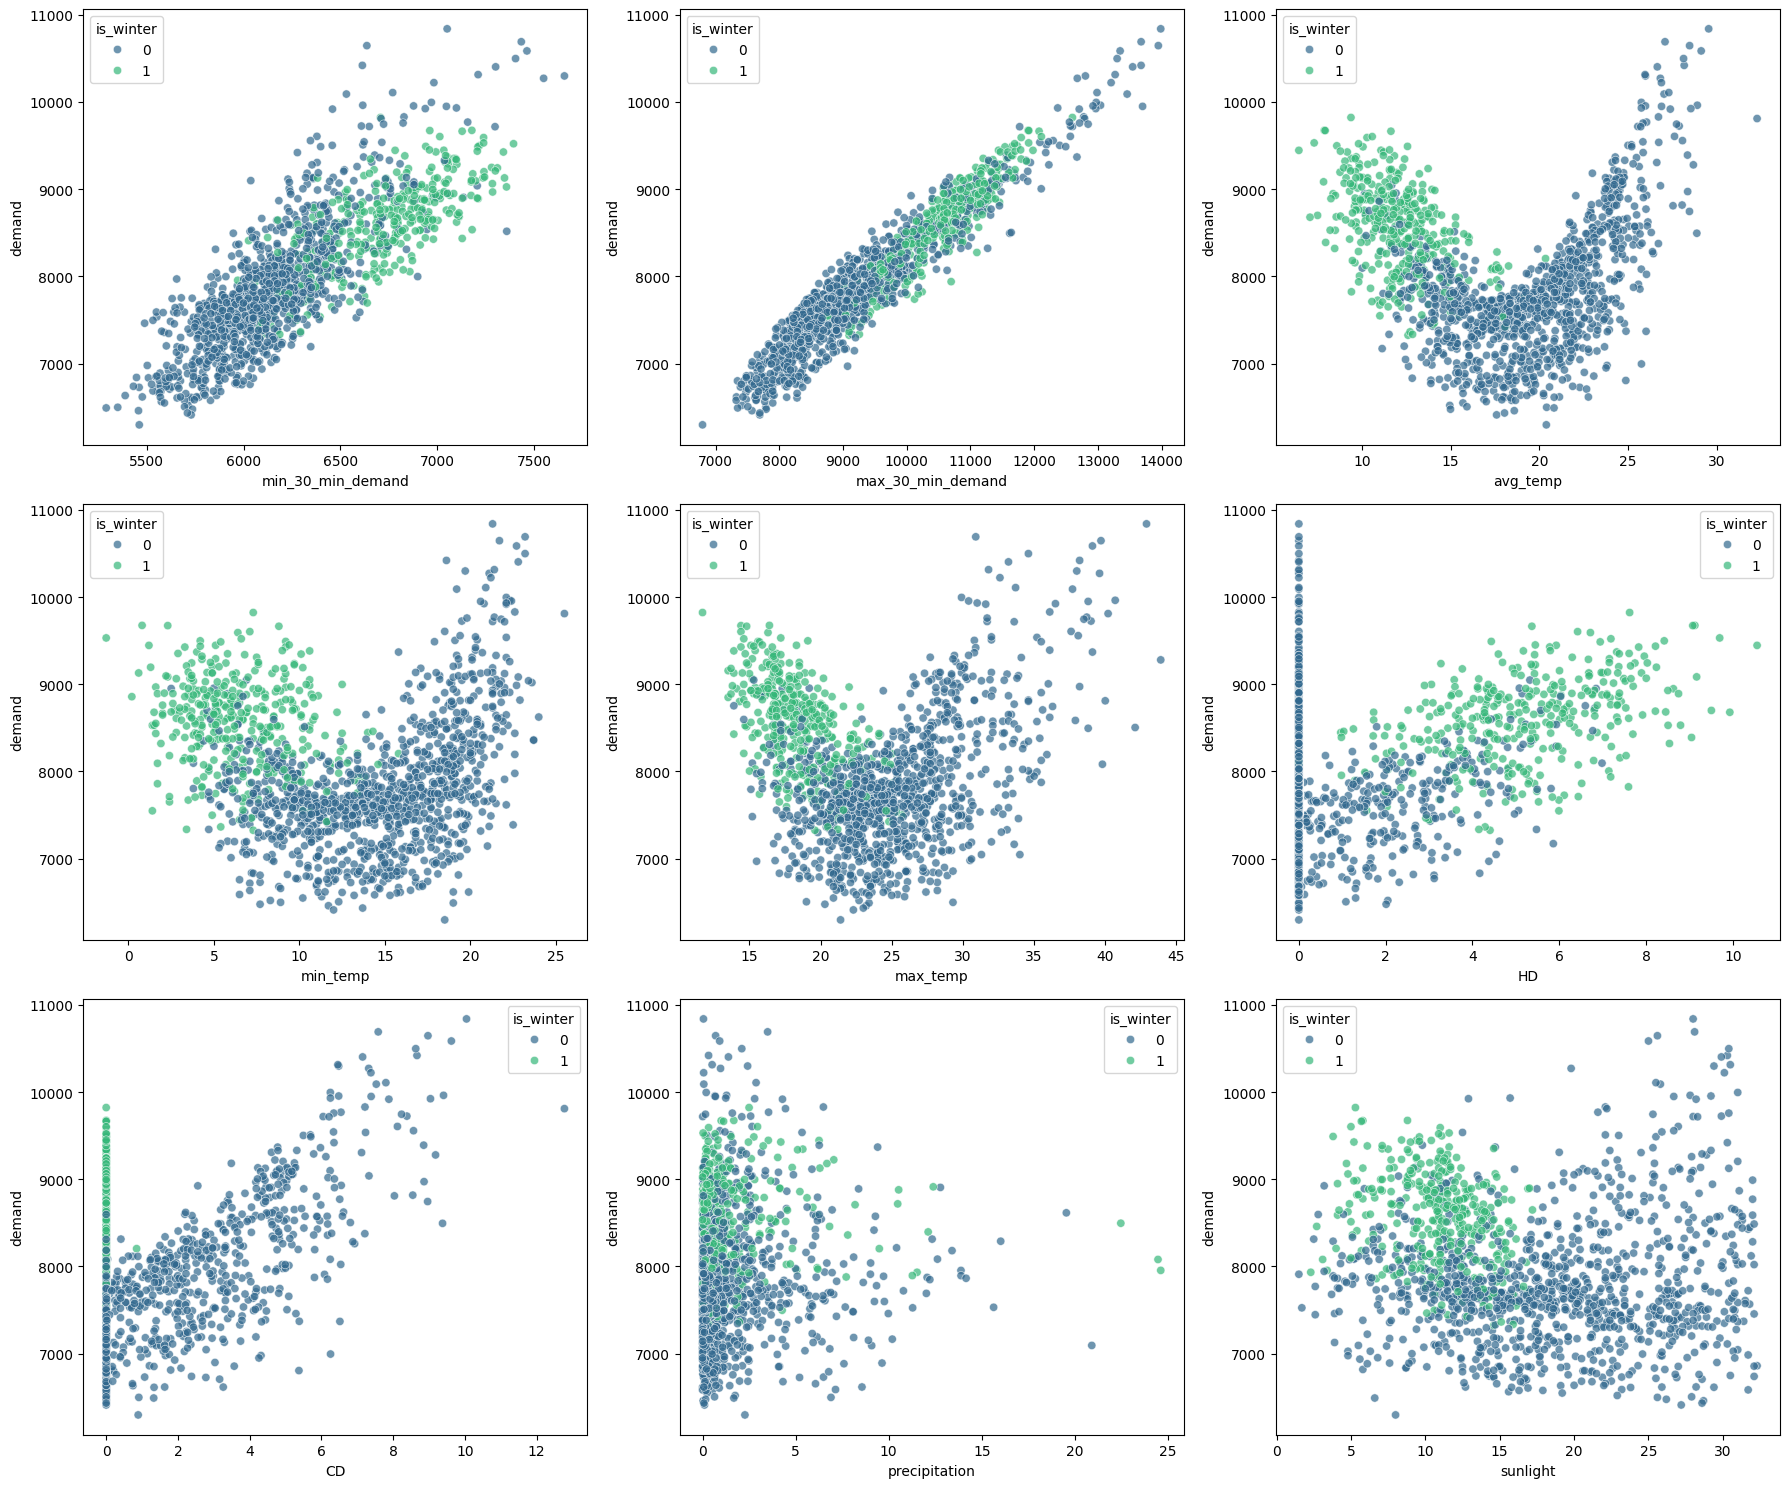

In [68]:
# To check for possible interactions of "is_winter" with any feature 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, var in enumerate(cont_vars):
    sns.scatterplot(data=bxp, x=var, y=response, hue="is_winter",
                    palette="viridis", alpha=0.7, ax=axes[i])
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j]) # to remove empty subplots

plt.tight_layout()

#NOTE: clear interaction of "is_winter" with min_demand, max_demand, avg_temp (min and max temp also), and sunlight
# is_winter:min_demand


## 2.4. Correlation heatmap

<Axes: >

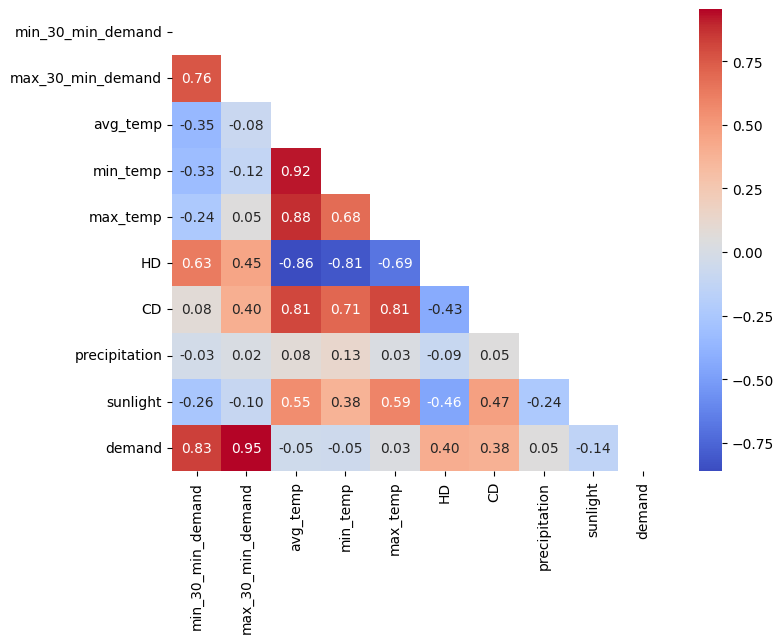

In [69]:
corr_vars = cont_vars + [response]
corr = dat1[corr_vars].corr()

# Correlation plot (upper triangle only)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)


# 3. Feature engineering

## 3.1. Select relevant variables

In [73]:
# Select only relevant variable
dat2 = dat1[["date", response, "is_weekend", "is_summer", "is_winter", "min_30_min_demand", "max_30_min_demand", 
             "avg_temp", "min_temp", "max_temp", "HD", "CD", 
             "precipitation", "sunlight"]]
dat2.head()

date       demand  is_weekend  is_summer  is_winter  \
0 2016-01-01  6861.518333           0          1          0   
1 2016-01-02  6731.957292           1          1          0   
2 2016-01-03  6618.040000           1          1          0   
3 2016-01-04  7358.550000           0          1          0   
4 2016-01-05  7460.061875           0          1          0   

   min_30_min_demand  max_30_min_demand   avg_temp  min_temp  max_temp   HD  \
0            5631.74            7913.75  20.704082      15.2      26.0  0.0   
1            5559.37            7390.04  20.572917      14.9      24.2  0.0   
2            5476.66            7328.39  21.130769      19.0      22.9  0.0   
3            5589.58            8313.11  20.144444      18.4      23.1  0.0   
4            5768.60            8338.82  18.904808      17.4      20.3  0.0   

         CD  precipitation  sunlight  
0  1.204082       2.140095      32.3  
1  1.072917       6.496326      23.2  
2  1.630769       8.562486      12.7  
3  0.644444       4.082204       7.6  
4  0.000000       9.977372       3.9

In [74]:
dat2 = dat2.copy()

# Create year and month features
dat2["year"] = dat2["date"].dt.year
dat2["month"] = dat2["date"].dt.month_name()
dat2.head()


date       demand  is_weekend  is_summer  is_winter  \
0 2016-01-01  6861.518333           0          1          0   
1 2016-01-02  6731.957292           1          1          0   
2 2016-01-03  6618.040000           1          1          0   
3 2016-01-04  7358.550000           0          1          0   
4 2016-01-05  7460.061875           0          1          0   

   min_30_min_demand  max_30_min_demand   avg_temp  min_temp  max_temp   HD  \
0            5631.74            7913.75  20.704082      15.2      26.0  0.0   
1            5559.37            7390.04  20.572917      14.9      24.2  0.0   
2            5476.66            7328.39  21.130769      19.0      22.9  0.0   
3            5589.58            8313.11  20.144444      18.4      23.1  0.0   
4            5768.60            8338.82  18.904808      17.4      20.3  0.0   

         CD  precipitation  sunlight  year    month  
0  1.204082       2.140095      32.3  2016  January  
1  1.072917       6.496326      23.2  2016  January  
2  1.630769       8.562486      12.7  2016  January  
3  0.644444       4.082204       7.6  2016  January  
4  0.000000       9.977372       3.9  2016  January

## 3.2. Holidays dummy feature

In [75]:
years = range(2016, 2020)
au_holidays = holidays.Australia(state="NSW", years=years)
au_holidays

# comparison on the same type
dat2 = dat2.copy()
dat2["is_holiday"] = dat2["date"].dt.date.isin(au_holidays).astype(int)

# Check again
print(dat2["is_holiday"].value_counts())
print(dat2["is_holiday"].value_counts(normalize=True))


is_holiday
0    1415
1      46
Name: count, dtype: int64
is_holiday
0    0.968515
1    0.031485
Name: proportion, dtype: float64


## 3.3. Add polynomial term Temp^2

In [78]:
# add temp^2 as a feature
dat2 = dat2.copy()
dat2["avg_temp2"] = dat2["avg_temp"] ** 2
dat2["min_temp2"] = dat2["min_temp"] ** 2
dat2["max_temp2"] = dat2["max_temp"] ** 2

dat2.head()


date       demand  is_weekend  is_summer  is_winter  \
0 2016-01-01  6861.518333           0          1          0   
1 2016-01-02  6731.957292           1          1          0   
2 2016-01-03  6618.040000           1          1          0   
3 2016-01-04  7358.550000           0          1          0   
4 2016-01-05  7460.061875           0          1          0   

   min_30_min_demand  max_30_min_demand   avg_temp  min_temp  max_temp   HD  \
0            5631.74            7913.75  20.704082      15.2      26.0  0.0   
1            5559.37            7390.04  20.572917      14.9      24.2  0.0   
2            5476.66            7328.39  21.130769      19.0      22.9  0.0   
3            5589.58            8313.11  20.144444      18.4      23.1  0.0   
4            5768.60            8338.82  18.904808      17.4      20.3  0.0   

         CD  precipitation  sunlight  year    month  is_holiday   avg_temp2  \
0  1.204082       2.140095      32.3  2016  January           1  428.658996   
1  1.072917       6.496326      23.2  2016  January           0  423.244900   
2  1.630769       8.562486      12.7  2016  January           0  446.509408   
3  0.644444       4.082204       7.6  2016  January           0  405.798642   
4  0.000000       9.977372       3.9  2016  January           0  357.391754   

   min_temp2  max_temp2  
0     231.04     676.00  
1     222.01     585.64  
2     361.00     524.41  
3     338.56     533.61  
4     302.76     412.09

# 4. Train-test splitting

In [77]:
reg_dat = dat2
#reg_dat['demand'] = np.log(reg_dat['demand'])
#reg_dat['min_30_min_demand'] = np.log(reg_dat['min_30_min_demand'])
#reg_dat['max_30_min_demand'] = np.log(reg_dat['max_30_min_demand'])


In [79]:
#reg_dat = dat2
#print(reg_dat.head())
#print(reg_dat.dtypes)
#reg_dat.to_excel("regression_data.xlsx", index=False)

# Split into train (2016–2018) and test (2019)
train = reg_dat[(reg_dat["date"] >= "2016-01-01") & (reg_dat["date"] <= "2018-12-31")]
test = reg_dat[(reg_dat["date"] >= "2019-01-01") & (reg_dat["date"] <= "2019-12-31")]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1096, 20)
Test shape: (365, 20)


In [80]:
# list of predictors and target
features = ["is_weekend", "is_summer", "is_winter", "is_holiday",
            "min_30_min_demand", "max_30_min_demand", "avg_temp", "avg_temp2",
              "min_temp", "min_temp2", "max_temp", "max_temp2","CD", "HD", "precipitation", "sunlight"]
target = "demand"

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# 5. Regression analysis

## 5.1. Baseline regression model

In [81]:
# Baseline regression model
mod_base = smf.ols("demand ~ is_weekend + is_summer+ is_winter + is_holiday + min_30_min_demand+  max_30_min_demand + avg_temp + avg_temp2+ " \
"min_temp + min_temp2 + max_temp + max_temp2  + CD + HD + precipitation + sunlight + is_summer:avg_temp + is_summer:sunlight + " \
" is_weekend:max_30_min_demand + is_summer:max_30_min_demand + is_summer:HD",
               data=train).fit()
print(mod_base.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2834.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        11:16:35   Log-Likelihood:                -6585.0
No. Observations:                1096   AIC:                         1.321e+04
Df Residuals:                    1074   BIC:                         1.332e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [82]:
# Get predictions
y_pred_mod_base = mod_base.fittedvalues
y_pred_tr_mod_base = mod_base.predict(train)
y_pred_ts_mod_base = mod_base.predict(test)

# Mean Absolute Percentage Error
mape_tr_mod_base = mean_absolute_percentage_error(y_train, y_pred_tr_mod_base)*100
mape_ts_mod_base = mean_absolute_percentage_error(y_test, y_pred_ts_mod_base)*100 

print(f"Train MAPE for baseline model is {mape_tr_mod_base:.2f}%")
print(f"Test MAPE for baseline model is {mape_ts_mod_base:.2f}%")


Train MAPE for baseline model is 0.97%
Test MAPE for baseline model is 1.77%


## 5.2. Random effects model

In [84]:
# Mixed effects regression with random intercepts for month
mod_re = smf.mixedlm("demand ~ is_weekend + is_summer+ is_winter + is_holiday + min_30_min_demand+  max_30_min_demand + avg_temp + avg_temp2+ " \
"min_temp + min_temp2 + max_temp + max_temp2  + CD + HD + precipitation + sunlight + is_summer:avg_temp + is_summer:sunlight + " \
" is_weekend:max_30_min_demand + is_summer:max_30_min_demand + is_summer:HD", 
data=train,
groups=train["month"],          # main grouping variable (random effect for month)
re_formula="1" )                # random intercept

# Fit the model
fit_re = mod_re.fit()
print(fit_re.summary())


                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        demand    
No. Observations:          1096           Method:                    REML      
No. Groups:                12             Scale:                     8400.0910 
Min. group size:           85             Log-Likelihood:            -6495.0345
Max. group size:           93             Converged:                 Yes       
Mean group size:           91.3                                                
-------------------------------------------------------------------------------
                              Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------
Intercept                    1262.841  211.496   5.971 0.000   848.316 1677.366
is_weekend                   -276.968   53.024  -5.223 0.000  -380.894 -173.043
is_summer                    -195.456   97.157  -2.012 0.044 

In [85]:
# Predictions
y_pred_tr_re1 = fit_re.predict(train)
y_pred_ts_re1 = fit_re.predict(test)

# MAPE
mape_tr_re1 = mean_absolute_percentage_error(y_train, y_pred_tr_re1) * 100
mape_ts_re1 = mean_absolute_percentage_error(y_test, y_pred_ts_re1) * 100

print(f"Train MAPE for first random effect model is {mape_tr_re1:.2f}%")
print(f"Test MAPE for first random effect model is {mape_ts_re1:.2f}%")
#NOTE: Very close to baseline model, adding months doen't improve model. 


Train MAPE for first random effect model is 1.02%
Test MAPE for first random effect model is 1.78%


In [86]:
mod_re2 = smf.mixedlm("demand ~ is_weekend + is_summer+ is_winter + is_holiday + min_30_min_demand+  max_30_min_demand + avg_temp + avg_temp2+ " \
"min_temp + min_temp2 + max_temp + max_temp2  + CD + HD + precipitation + sunlight + is_summer:avg_temp + is_summer:sunlight + " \
" is_weekend:max_30_min_demand + is_summer:max_30_min_demand + is_summer:HD",
    data=train,
    groups=train["year"],   #main grouping = year
    vc_formula={"month": "0 + C(month)"} )  # add random intercept for month

fit_re2 = mod_re2.fit()
print(fit_re2.summary())


                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        demand    
No. Observations:          1096           Method:                    REML      
No. Groups:                3              Scale:                     6548.3231 
Min. group size:           365            Log-Likelihood:            -6396.9179
Max. group size:           366            Converged:                 Yes       
Mean group size:           365.3                                               
-------------------------------------------------------------------------------
                              Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------
Intercept                     966.169  191.621   5.042 0.000   590.598 1341.740
is_weekend                   -333.152   47.301  -7.043 0.000  -425.860 -240.445
is_summer                    -150.091   85.127  -1.763 0.078 

In [87]:
# Predictions
tr_pred_re2 = fit_re2.predict(train)
ts_pred_re2 = fit_re2.predict(test)

# MAPE
mape_tr_re2 = mean_absolute_percentage_error(y_train, tr_pred_re2) * 100
mape_ts_re2 = mean_absolute_percentage_error(y_test, ts_pred_re2)  * 100

print(f"Train MAPE for second mixed effect model is {mape_tr_re2:.2f}%")
print(f"Test MAPE for second mixed effect model is {mape_ts_re2:.2f}%")
#NOTE: No improvement over baseline model.


Train MAPE for second mixed effect model is 1.03%
Test MAPE for second mixed effect model is 1.84%


# 6. Machine learning models

## 6.1. Random forest

In [88]:
rf_train = train
rf_test = test

In [90]:
# Add interaction features for machine learning models
"demand ~ is_weekend + is_summer+ is_winter + is_holiday + min_30_min_demand+  max_30_min_demand + avg_temp + avg_temp2+ " \
"min_temp + min_temp2 + max_temp + max_temp2  + CD + HD + precipitation + sunlight + is_summer:avg_temp + is_summer:sunlight + " \
" is_weekend:max_30_min_demand + is_summer:max_30_min_demand + is_summer:HD"

rf_train["is_summer_avg_temp"] = rf_train["is_summer"] * rf_train["avg_temp"]
rf_train["is_summer_sunlight"] = rf_train["is_summer"] * rf_train["sunlight"]
rf_train["is_weekend_max_30_min_demand"] = rf_train["is_weekend"] * rf_train["max_30_min_demand"]
rf_train["is_summer_max_30_min_demand"] = rf_train["is_summer"] * rf_train["max_30_min_demand"]
rf_train["is_summer_HD"] = rf_train["HD"] * rf_train["is_summer"]

rf_test["is_summer_avg_temp"] = rf_test["is_summer"] * rf_test["avg_temp"]
rf_test["is_summer_sunlight"] = rf_test["is_summer"] * rf_test["sunlight"]
rf_test["is_weekend_max_30_min_demand"] = rf_test["is_weekend"] * rf_test["max_30_min_demand"]
rf_test["is_summer_max_30_min_demand"] = rf_test["is_summer"] * rf_test["max_30_min_demand"]
rf_test["is_summer_HD"] = rf_test["HD"] * rf_test["is_summer"]

# Updated features
ml_features = ["is_weekend", "is_summer", "is_winter", "is_holiday",
               "min_30_min_demand", "max_30_min_demand", "avg_temp", "avg_temp2",
               "min_temp", "min_temp2", "max_temp", "max_temp2", "CD", "HD", "precipitation",
               "is_summer_avg_temp", "is_summer_sunlight",
               "is_weekend_max_30_min_demand", "is_summer_max_30_min_demand",
               "is_summer_HD"]

X_rf_train = rf_train[ml_features]
y_rf_train = rf_train["demand"]
X_rf_test = rf_test[ml_features]
y_rf_test = rf_test["demand"]


C:\Users\user\AppData\Local\Temp\ipykernel_48064\2824248023.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_train["is_summer_avg_temp"] = rf_train["is_summer"] * rf_train["avg_temp"]
C:\Users\user\AppData\Local\Temp\ipykernel_48064\2824248023.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_train["is_summer_sunlight"] = rf_train["is_summer"] * rf_train["sunlight"]
C:\Users\user\AppData\Local\Temp\ipykernel_48064\2824248023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [91]:
# Fit Random Forest
rf0 = RandomForestRegressor(n_estimators=500, #number of trees
                           max_depth=None,  #to let trees grow deep
                           random_state=42,
                           n_jobs=-1)
rf0.fit(X_rf_train, y_rf_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [92]:
# Predictions
y_pred_tr_rf0 = rf0.predict(X_rf_train)
y_pred_ts_rf0 = rf0.predict(X_rf_test)

# Evaluation
mape_tr_rf0 = mean_absolute_percentage_error(y_rf_train, y_pred_tr_rf0) * 100
mape_ts_rf0 = mean_absolute_percentage_error(y_rf_test, y_pred_ts_rf0) * 100
print(f"Train MAPE for initial RF is {mape_tr_rf0:.2f}%")
print(f"Test MAPE for initial RF is  {mape_ts_rf0:.2f}%")
#Seems a bit overfitted model...?


Train MAPE for initial RF is 0.43%
Test MAPE for initial RF is  1.91%


<Axes: >

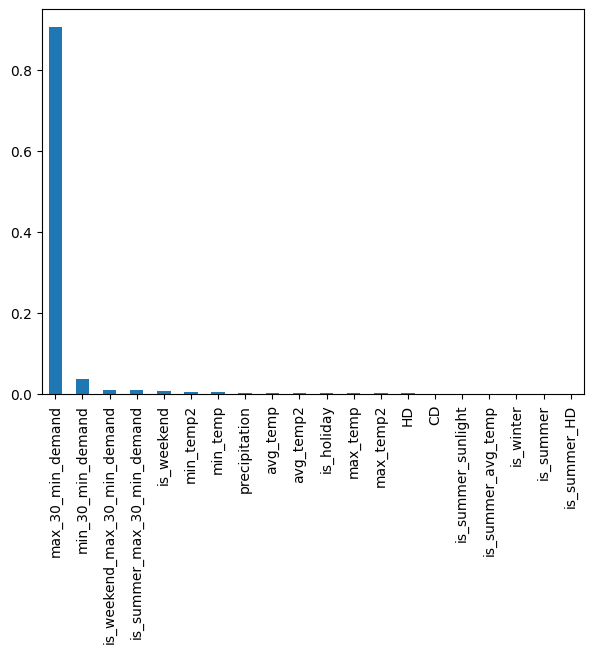

In [93]:
# Feature importance using random forest
feat_imp = pd.Series(rf0.feature_importances_, index=ml_features).sort_values(ascending=False)
plt.figure(figsize=(7,5))
feat_imp.plot(kind="bar")


In [102]:
# Hyper-parameter tuning (Grid search) of Random forest (rf0)
param_grid_rf = {"n_estimators": [200, 500, 1000],
              "max_depth": [5, 10, 20],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_features": ["sqrt", "log2", 0.5]}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid_rf, cv=5,
                    scoring="neg_mean_absolute_percentage_error", verbose=2)
grid_rf.fit(X_rf_train, y_rf_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; tot

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2', 0.5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 500, 1000]},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [103]:
best_rf_grid = grid_rf.best_estimator_
print(grid_rf.best_params_)

{'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [104]:
# Fit Random Forest
best_grid_rf = RandomForestRegressor(max_features=0.5, min_samples_leaf= 1, min_samples_split= 2, n_estimators=1000,
                                     max_depth=20, random_state=42, n_jobs=-1)
best_grid_rf.fit(X_rf_train, y_rf_train)

RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [105]:
# Predictions
y_pred_tr_rf1 = best_grid_rf.predict(X_rf_train)
y_pred_ts_rf1 = best_grid_rf.predict(X_rf_test)

# Evaluation
mape_tr_rf1 = mean_absolute_percentage_error(y_rf_train, y_pred_tr_rf1) * 100
mape_ts_rf1 = mean_absolute_percentage_error(y_rf_test, y_pred_ts_rf1) * 100
print(f"Train MAPE for hyper-parameter tuned RF is {mape_tr_rf1:.2f}%")
print(f"Test MAPE for hyper-parameter tuned RF is {mape_ts_rf1:.2f}%")
#NOTE: Not improved over basic RF.


Train MAPE for hyper-parameter tuned RF is 0.40%
Test MAPE for hyper-parameter tuned RF is 1.89%


## 6.2. XGBoost

In [94]:
xgb0 = XGBRegressor(n_estimators=1000, learning_rate=0.01, 
                    max_depth=4, subsample=0.7, colsample_bytree=0.7,  random_state=42)
xgb0.fit(X_rf_train, y_rf_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [95]:
y_pred_tr_xgb0 = xgb0.predict(X_rf_train)
y_pred_ts_xgb0 = xgb0.predict(X_rf_test)

mape_tr_xgb0 = mean_absolute_percentage_error(y_train, y_pred_tr_xgb0) * 100
mape_ts_xgb0 = mean_absolute_percentage_error(y_test, y_pred_ts_xgb0) * 100
print(f"Train MAPE by basic XGB is {mape_tr_xgb0:.2f}%")
print(f"Test MAPE by basic XGB is {mape_ts_xgb0:.2f}%")


Train MAPE by basic XGB is 0.63%
Test MAPE by basic XGB is 1.86%


In [96]:
# Hyper-parameter tuning of XGB (Grid-search)
param_grid_xgb = {"n_estimators": [500, 1000, 1500],
                  "max_depth": [3, 4, 5, 6],
                  "learning_rate": [0.01, 0.05, 0.1],
                  "subsample": [0.6, 0.7, 0.8, 1.0],
                  "colsample_bytree": [0.6, 0.7, 0.8, 1.0], 
                  "min_child_weight": [1, 3, 5],
                  "gamma": [0, 0.1, 0.3, 0.5],
                  "reg_lambda": [1, 1.5, 2]}

xgb_tuned0 = XGBRegressor(random_state=42)

grid_search_xgb = RandomizedSearchCV(xgb_tuned0, param_distributions=param_grid_xgb, 
                                     n_iter=30, scoring="neg_mean_absolute_error", 
                                     cv=5, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_rf_train, y_rf_train)
print("Best params of grid search XGB is", grid_search_xgb.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params of grid search XGB is {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [97]:
# Refit XGB-boost with the best parameters
xgb_grid_best = XGBRegressor(subsample=0.8, reg_lambda=1, n_estimators=1000, min_child_weight=5, 
                             max_depth=3, learning_rate=0.01, gamma=0.3, colsample_bytree=0.8, random_state=42)

# Fit on training set
xgb_grid_best.fit(X_rf_train, y_rf_train)

# Predictions
y_pred_tr_xgbbest = xgb_grid_best.predict(X_rf_train)
y_pred_ts_xgbbest = xgb_grid_best.predict(X_rf_test)

# Compute MAPE
mape_tr_xgbbest = mean_absolute_percentage_error(y_train, y_pred_tr_xgbbest) * 100
mape_ts_xgbbest = mean_absolute_percentage_error(y_test, y_pred_ts_xgbbest) * 100

print(f"Train MAPE after hyperparameter tuned XGB is {mape_tr_xgbbest:.2f}%")
print(f"Test MAPE after hyperparameter tuned XGB is {mape_ts_xgbbest:.2f}%")


Train MAPE after hyperparameter tuned XGB is 0.77%
Test MAPE after hyperparameter tuned XGB is 1.84%


# 7. Time series model

## 7.1. SARIMAX

In [98]:
# Exogenous regressors; only adding main variables
exog_vars = ["min_30_min_demand", "max_30_min_demand", "avg_temp2", "min_temp2", "max_temp2",
             "sunlight", "HD", "CD", "is_weekend", "is_holiday"]
Xts_train = train[exog_vars]
Xts_test = test[exog_vars]

ADF Statistic: -3.36
p-value: 0.01


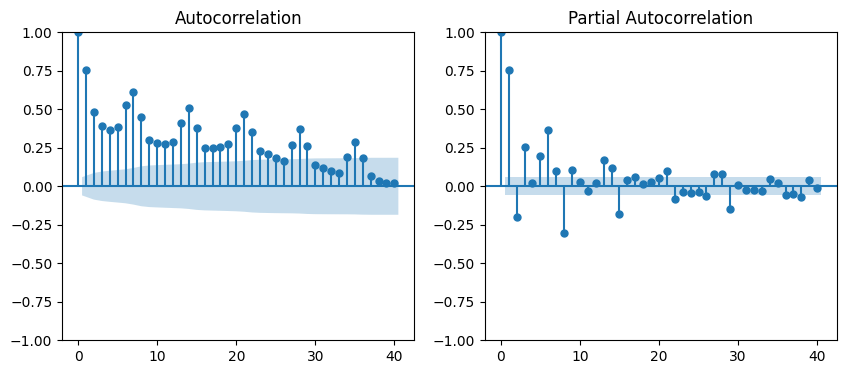

In [99]:
# Check stationarity
result = adfuller(y_train)
print("ADF Statistic:", result[0].round(2))
print("p-value:", result[1].round(2))
#NOTE: since, p<0.05, time series of demand is stationary.


# Plot ACF and PACF (This is done to check the order of ARIMA)
fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_acf(y_train, lags=40, ax=ax[0])
plot_pacf(y_train, lags=40, ax=ax[1])
plt.show()
#NOTE: ACF shows slow decay (gradual decline across many lags). We can take MA(q) as 1 or 2
#PACF has a large spike at lag 1, then smaller spikes at lag 2–3. 
# After lag 3, most lags hover near zero (some mild significance up to ~10). This suggests an AR(p) process, likely with p=1,2, or 3.
# d= 0 because of stationarity (confirmed by ADF)
# So ARIMA (p,d,q) can be (1, 0, 1)

In [100]:
# Fit SARIMAX model
sarimax = SARIMAX(y_train, exog=Xts_train, order=(2,0,2),  # ARIMA(p,d,q)
                  seasonal_order=(1,1,1,7),  # weekly seasonality
                  enforce_stationarity=False,
                  enforce_invertibility=False)

fit_sarimax = sarimax.fit(disp=False)
print(fit_sarimax.summary())

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                 1096
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -6253.001
Date:                             Wed, 17 Sep 2025   AIC                          12540.003
Time:                                     11:23:43   BIC                          12624.727
Sample:                                          0   HQIC                         12572.085
                                            - 1096                                         
Covariance Type:                               opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
min_30_min_demand     0.5020      0.019     26.116      0.000       0.464       0.540
max_30

In [101]:
# Predictions
y_pred_tr_sarima = fit_sarimax.predict(start=y_train.index[0], end=y_train.index[-1], exog=Xts_train)
y_pred_ts_sarima = fit_sarimax.predict(start=y_test.index[0], end=y_test.index[-1], exog=Xts_test)

# Compute MAPE
mape_tr_sarima = mean_absolute_percentage_error(y_train, y_pred_tr_sarima) * 100
mape_ts_sarima = mean_absolute_percentage_error(y_test, y_pred_ts_sarima) * 100

print(f"Train MAPE for SARIMA is {mape_tr_sarima:.2f}%")
print(f"Test MAPE for SARIMA is {mape_ts_sarima:.2f}%")
#NOTE: ML models are doing better than time series models.

Train MAPE for SARIMA is 0.79%
Test MAPE for SARIMA is 1.47%
